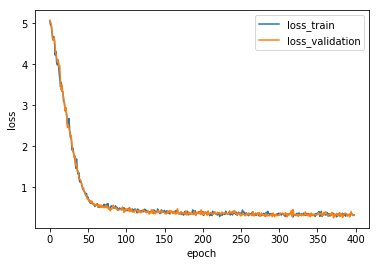

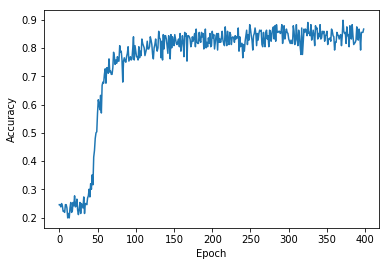

0.328599858407
0.329528302198


In [9]:
from sklearn import datasets, model_selection
import numpy as np
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

def sigmoid(inX):  
    return 1.0 / (1 + np.exp(-inX))

def train(X_train, Y_train, theta, learning_rate, optimization, optimizer_params, t):
    gradient = 1.0/X_train.shape[0] * np.dot(X_train.transpose(), sigmoid(X_train.dot(theta))-Y_train)
    if optimization == 'initial':        
        theta -= learnign_rate * gradient
    elif optimization == 'NAG':       
        V = optimizer_params.setdefault('V', np.zeros(theta.shape))
        M = optimizer_params.setdefault('M', 0.9)           
        gradient = 1.0/X_train.shape[0] * np.dot(X_train.transpose(), sigmoid(X_train.dot(theta+V*M))-Y_train)
        V = V * M - learning_rate*gradient
        theta += V
        optimizer_params['V'] = V
    elif optimization == 'RMSprop':
        V = optimizer_params.setdefault('V', np.zeros(theta.shape))
        rms_decay = optimizer_params.setdefault('rms_decay', 0.02)
        epsilon = optimizer_params.setdefault('epsilon', 0.001)
        V = rms_decay*V + (1-rms_decay)*(gradient**2)            
        theta -= learning_rate*gradient/(np.sqrt(epsilon) + V)    
        optimizer_params['V'] = V
    elif optimization == "Adadelta":
        V = optimizer_params.setdefault('V', np.zeros(theta.shape))
        update_accumulate = optimizer_params.setdefault('update_accumulate', np.zeros(theta.shape))
        ada_decay = optimizer_params.setdefault('ada_decay', 0.9)
        epsilon = optimizer_params.setdefault('epsilon', 0.001)
        V = ada_decay*V + (1-ada_decay)*(gradient**2)
        step_update = -(np.sqrt(update_accumulate+epsilon))*gradient/(np.sqrt(V+epsilon))
        theta +=  step_update
        update_accumulate = ada_decay*update_accumulate + (1-ada_decay)*(step_update**2)            
        optimizer_params['update_accumulate'] = update_accumulate
        optimizer_params['V'] = V
    elif optimization == "Adam":    
        V = optimizer_params.setdefault('V', np.zeros(theta.shape))
        S = optimizer_params.setdefault('S', np.zeros(theta.shape))
        Beta1 =  optimizer_params.setdefault('beta1', 0.9)
        Beta2 = optimizer_params.setdefault('beta2', 0.999)
        epsilon = optimizer_params.setdefault('epsilon', 0.001)
        S = Beta1*S + (1-Beta1)*gradient
        V = Beta2*V + (1-Beta2)*(gradient**2)  
        S_t = S/(1 - (Beta1**t))
        V_t = V/(1- (Beta2**t))
        step_update = - learning_rate * S_t/ (np.sqrt(V_t) + epsilon)
        theta += step_update
        optimizer_params['S'] = S
        optimizer_params['V'] = V
    return theta

def load_data(file, n_features=None):
    if n_features == None:    
        X, Y = datasets.load_svmlight_file(file)
    else:
        X, Y = datasets.load_svmlight_file(file, n_features=n_features)       
    one = np.ones((X.shape[0], 1))
    X = hstack([X, csr_matrix(one)]).toarray()
    Y = np.array(Y).reshape(X.shape[0], 1)
    Y[Y==-1] = 0
    return X, Y

def loss_function(X, Y, theta):
    loss = -1.0 / X.shape[0] * (Y * np.log(sigmoid(X.dot(theta)) ) +  (1 - Y) * np.log(1-sigmoid(X.dot(theta)) ) ) .sum()
    return loss

def array_set(X, Y , num):
    index = np.random.randint(0,X.shape[0], size=num, dtype=int)
    return X[index,:], Y[index]

def count_accuracy(X, Y, theta, threshold):    
    prediction_Y = sigmoid(X.dot(theta))
    prediction_Y[prediction_Y<=threshold] = 0
    prediction_Y[prediction_Y>threshold] = 1
    accuracy = len(np.where((Y-prediction_Y)==0)[0])/(Y-prediction_Y).shape[0]
    return accuracy

def plt_loss(epoch, learning_rate, optimization=None):
    X_train, Y_train =load_data('a9a')
    X_test, Y_test = load_data('a9a.t', X_train.shape[1]-1)
    theta = np.random.random((X_train.shape[1], 1))
    loss_training = []
    loss_validation = []
    Accuracy = []
    threshold = 0.5
    for t in range (1, epoch):
        X_training, Y_training = array_set(X_train, Y_train, num = 256)
        X_testing, Y_testing = array_set(X_test, Y_test, num = 256)         
        theta = train(X_training, Y_training, theta, learning_rate, optimization, optimizer_params, t=t)
        loss = loss_function(X_training, Y_training, theta)
        loss_training.append(loss)
        Loss = loss_function(X_testing, Y_testing, theta)
        loss_validation.append(Loss)
        this_accuracy = count_accuracy(X_testing, Y_testing, theta, threshold)
        Accuracy.append(this_accuracy)
    figure1 = plt.figure(1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_training, label='loss_train')
    plt.plot(loss_validation, label='loss_validation')
    plt.legend(loc='upper right')
    plt.show()

    plt.figure(2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(Accuracy)
    plt.show()
    print(loss)
    print(Loss)

if __name__ =="__main__":
    optimizer_params={
        'M': 0.9,
        'rms_decay': 0.02,
        'epsilon':0.001
    }
    learning_rate = 0.01
    epoch = 400
    optimization = 'Adam'
    plt_loss(epoch = epoch, learning_rate = learning_rate, optimization = optimization)


    
